
# AI ACADEMY - COLLECTING DATA FROM YOUTUBE VIA Youtube3 API
###> SUPERVISOR: VAN NAM DANG
###> TEAM      : TOMMY NGUYEN, LILY VU
##FINAL Project: NLP Vietnamese for Python Class
###Update: 12-11-2020



In [ ]:
!nvidia-smi

Fri Nov 13 12:55:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Cài đặt vài thứ linh tinh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install plotly==4.12.0
!pip install "notebook>=5.3" "ipywidgets>=7.2"
!pip install chart-studio==1.0.0
!pip install plotly-geo==1.0.0
!pip install psutil
!pip install -U kaleido
!pip install plotly_express

Requirement already up-to-date: kaleido in /usr/local/lib/python3.6/dist-packages (0.0.3.post1)


In [ ]:
!apt-get install python3-venv
!python3 -m venv collect_comments
!source collect_comments/bin/activate

!pip install ipython-autotime
%load_ext autotime
#%unload_ext autotime
import datetime
now = datetime.datetime.now()
print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-venv is already the newest version (3.6.7-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Done process at :  2020-11-13 12:55:47
time: 480 µs


In [ ]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# -*- coding: utf-8 -*-
from __future__ import print_function
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import SGDClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestClassifier
import pandas as pd
#from pyvi import ViTokenizer
import re
import string
import codecs


# Any results you write to the current directory are saved as output.

time: 1.22 s


In [ ]:
%cd '/content/collect_comments'
#!pip3 install -r requirements.txt
!pip install --upgrade google-api-python-client
print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
!apt install wget
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))

## Tạo các hàm chuẩn hoá dữ liệu

In [ ]:
#Setup thư viện xử lý tiếng việt
!pip install pyvi
from pyvi import ViTokenizer

time: 2.07 s


In [ ]:
#Từ điển tích cực, tiêu cực, phủ định
path_nag = '/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Vi dụ demo/Data/sentiment_dicts/nag_youtube.txt'
path_pos = '/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Vi dụ demo/Data/sentiment_dicts/pos_youtube.txt'
path_not = '/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Vi dụ demo/Data/sentiment_dicts/not.txt'
#-------------------------------------------------------------------------------------------------
with codecs.open(path_nag, 'r', encoding='UTF-8') as f:
    nag = f.readlines()
nag_list = [n.replace('\n', '') for n in nag]

with codecs.open(path_pos, 'r', encoding='UTF-8') as f:
    pos = f.readlines()
pos_list = [n.replace('\n', '') for n in pos]
with codecs.open(path_not, 'r', encoding='UTF-8') as f:
    not_ = f.readlines()
not_list = [n.replace('\n', '') for n in not_]


#Xây dựng hàm chuẩn hóa dữ liệu tiêng việt
def normalize_text(text):

    #Remove các ký tự kéo dài: vd: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    # Chuyển thành chữ thường
    text = text.lower()

    #Chuẩn hóa tiếng Việt, xử lý emoj, chuẩn hóa tiếng Anh, thuật ngữ
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "negative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
        "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' negative ', '😣': ' negative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' negative ', '😢': ' negative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' negative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' negative ', '😭': ' negative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' negative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' negative ', '😀': ' positive ', ':((': ' negative ', '😡': ' negative ', '😠': ' negative ',
        '😒': ' negative ', '🙂': ' positive ', '😏': ' negative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' negative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' negative ', '😓': ' negative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' negative ', ':3': ' positive ', '😫': ' negative ', '😥': ' negative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' negative ', '😑': ' negative ', '🔥': ' positive ', '🙏': ' negative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' negative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' negative ',  '💀': ' negative ',
        '😔': ' negative ', '😧': ' negative ', '😩': ' negative ', '😰': ' negative ', '😳': ' negative ',
        '😵': ' negative ', '😶': ' negative ', '🙁': ' negative ', '🐔': ' negative ', '🐓': ' negative ',
        '🐕': ' negative ','😼': ' negative ','🐶': ' negative ','😵': ' negative ','😕': ' negative ',
        '😒': ' negative ','😐': ' negative ','❤️': ' positive ','😍': ' positive ','🤗': ' positive ',
        '😘': ' positive ','👍': ' positive ','❤': ' positive ','😙': ' positive ','💪🏻': ' positive ',
        '👍': ' positive ','👍🏻': ' positive ','❣👏': ' positive ','😻': ' positive ','💘': ' positive ',
        
	  
        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' negative ',' cc ': ' negative ','cute': u' dễ thương ','huhu': ' negative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}

    for k, v in replace_list.items():
        text = text.replace(k, v)

    # Thực hiện chuyển đổi các dấu câu thành space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)

    text = ViTokenizer.tokenize(text)
    texts = text.split()
    len_text = len(texts)

    texts = [t.replace('_', ' ') for t in texts]
    for i in range(len_text):
        cp_text = texts[i]
        if cp_text in not_list: # Xử lý vấn đề phủ định (VD: áo này chẳng đẹp--> áo này notpos)
            numb_word = 2 if len_text - i - 1 >= 4 else len_text - i - 1

            for j in range(numb_word):
                if texts[i + j + 1] in pos_list:
                    texts[i] = 'notpos'
                    texts[i + j + 1] = ''

                if texts[i + j + 1] in nag_list:
                    texts[i] = 'notnag'
                    texts[i + j + 1] = ''
        else: #Thêm feature cho những sentiment words (áo này đẹp--> áo này đẹp positive)
            if cp_text in pos_list:
                texts.append('positive')
            elif cp_text in nag_list:
                texts.append('negative')

    text = u' '.join(texts)

    #remove nốt những ký tự thừa thãi
    text = text.replace(u'"', u' ')
    text = text.replace(u'️', u'')
    text = text.replace('🏻','')
    return text

print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))

#Xây dựng Hàm bỏ dấu trong tiếng việt (Chuyển từ tiếng việt có dấu --> không dấu)
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER

def no_marks(s):
    __INTAB = [ch for ch in VN_CHARS]
    __OUTTAB = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"*2
    __OUTTAB += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"*2
    __r = re.compile("|".join(__INTAB))
    __replaces_dict = dict(zip(__INTAB, __OUTTAB))
    result = __r.sub(lambda m: __replaces_dict[m.group(0)], s)
    return result

print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))

Done process at :  2020-11-13 12:55:47
Done process at :  2020-11-13 12:55:47
time: 345 ms


## Tải dữ liêu vào các dataframe

In [ ]:
import pandas as pd

lactroi = pd.read_csv('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Data_Comment/clean_lactroi_binhluan_31k.csv', lineterminator='\n')
print(lactroi.shape)
print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))

lactroi = lactroi[['clear_all', 'clean_comment', 'text_length', 'Like Count']]
#pd.set_option('display.max_rows', 100)
lactroi.head(5)

(31007, 10)
Done process at :  2020-11-13 06:35:49


,clear_all,clean_comment,text_length,Like Count
0,lạc trôi (triple d remix) | 360 degree mv | s...,lạc trôi (triple d remix) | 360 degree mv | s...,36,27410
1,231m ai còn nghe ko,231m ai còn nghe ko,5,1
2,bn tôi nay có tâm sự à,bn tôi nay có tâm sự à,7,1
3,vấn vuong,vấn vuong,2,1
4,nghiện nghiện nghiện say say say\nvấn vương...!,nghiện nghiện nghiện say say say\nvấn vương...!,8,2


time: 1.52 s


In [ ]:
tuhomnay = pd.read_csv('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Data_Comment/clean_TuHomNay_binhluan_45k.csv', lineterminator='\n')
print(tuhomnay.shape)
print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))

tuhomnay.rename(columns={'Clear_all': 'clear_all'}, inplace=True)
tuhomnay = tuhomnay[['clear_all', 'clean_comment', 'text_length', 'Like Count']]
#pd.set_option('display.max_rows', 100)
tuhomnay.head(5)

(45182, 10)
Done process at :  2020-11-13 06:35:49


,clear_all,clean_comment,text_length,Like Count
0,oh likes nhiều mà,oh likes nhiều mà,4,0
1,không biết bây giờ chipu còn đóng 5s,không biết bây giờ chipu còn đóng 5s,8,0
2,hay quá chị ơi em yêu chị,hay quá chị ơi em yêu chị,7,1
3,2020 vẫn coi,2020 vẫn coi,3,0
4,16/10/2020 nghe lại vẫn hay chất lừ,16/10/2020 nghe lại vẫn hay chất lừ😊,7,0


time: 958 ms


In [ ]:
htca = pd.read_csv('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Data_Comment/clean_htca_binhluan_521k.csv', lineterminator='\n')
print(htca.shape)
print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))
htca.rename(columns={'clean_comment.1': 'clear_all'}, inplace=True)
htca = htca[['clear_all', 'clean_comment', 'text_length', 'Like Count']]
pd.set_option('display.max_rows', 100)
htca.head(5)

(521870, 10)
Done process at :  2020-11-13 06:35:49


,clear_all,clean_comment,text_length,Like Count
0,ngăn giọt lệ ngừng khiến khoé mi sầu biiiii,ngăn giọt lệ ngừng khiến khoé mi sầu biiiii,9,0
1,cá heo,cá heo,2,1
2,mv đỉnh nhất vn thời đại,mv đỉnh nhất vn thời đại,6,0
3,hay quá anh ơi,hay quá anh ơi,4,2
4,31/10 ai còn nghe ko,31/10 ai còn nghe ko,5,1


time: 2.69 s


# Bắt đầu chém gió


### TỪ HÔM NAY

In [ ]:
import collections
from collections import Counter

tuhomnay['temp_list'] = tuhomnay['clean_comment'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tuhomnay['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='afmhot_r')


,Common_words,count
0,hay,17955
1,hát,14453
2,chi,11606
3,mà,11429
4,là,11166
5,có,10658
6,nghe,10494
7,chị,9278
8,thì,9063
9,bài,8028


time: 381 ms


In [ ]:
import pandas as pd
import plotly
import plotly_express as px

#pd.options.plotting.backend = "plotly" 

fig = px.bar(temp, x="count", y="Common_words", title='Từ Thông Dụng của #Từ Hôm Nay', orientation='h', width=700, height=700,color='Common_words')
fig.show()

time: 713 ms


In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Phân Bổ của Từ Ngữ #Từ Hôm Nay')
fig.show()

time: 73.5 ms


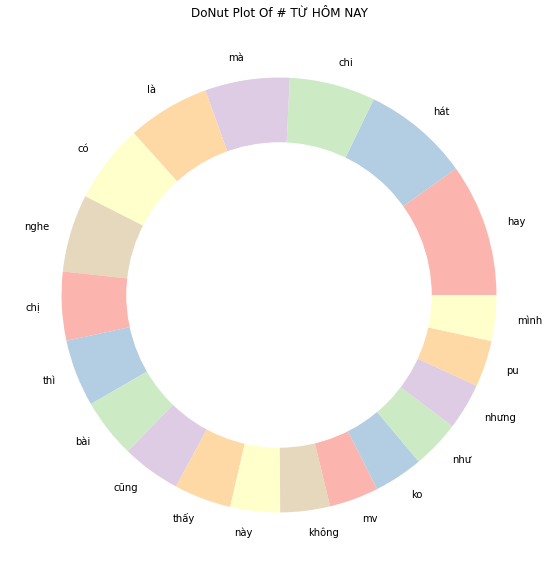

time: 142 ms


In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp['count'], labels=temp.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of # TỪ HÔM NAY')
plt.show()

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(13.0,8.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=100, 
                    height=60,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

time: 10.7 ms


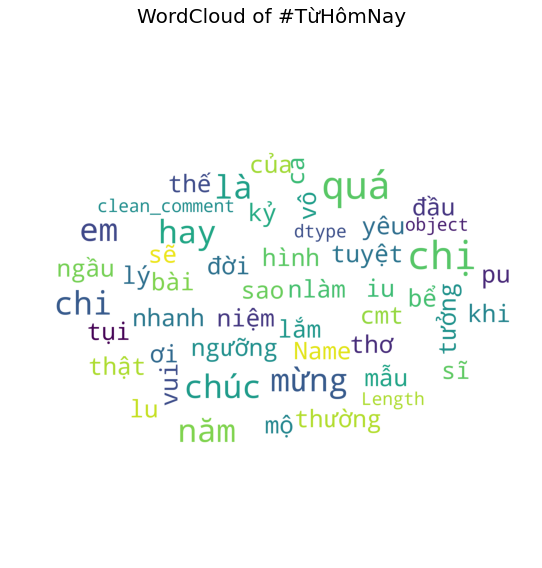

time: 3.1 s


In [ ]:



d = '/kaggle/input/masks-for-wordclouds/'
#Neutral_sent = tuhomnay[tuhomnay['clean_comment']!= 0]
Neutral_sent = tuhomnay[tuhomnay['Like Count']!= 0]
#pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
pos_mask = np.array(Image.open('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Vi dụ demo/comment.png'))
plot_wordcloud(Neutral_sent.clean_comment,mask=pos_mask,color='white',max_font_size=150,title_size=20,title="WordCloud of #TừHômNay")

### Lạc Rang

In [ ]:
import collections
from collections import Counter

lactroi['temp_list'] = lactroi['clear_all'].apply(lambda x:str(x).split())
top = Counter([item for sublist in lactroi['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='afmhot_r')


,Common_words,count
0,ai,6271
1,nghe,5881
2,còn,4861
3,xem,3092
4,lạc,2956
5,có,2719
6,trôi,2655
7,hay,2643
8,vẫn,2548
9,tùng,2184


time: 108 ms


In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Phân Bổ của Từ Ngữ #LạcTrôi')
fig.show()

time: 54.7 ms


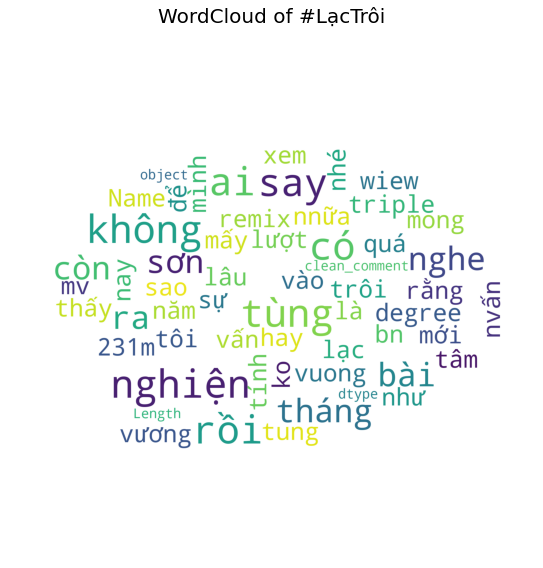

time: 3.73 s


In [ ]:
Neutral_sent = lactroi[lactroi['Like Count']!= 0]
#pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
pos_mask = np.array(Image.open('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Vi dụ demo/comment.png'))
plot_wordcloud(Neutral_sent.clean_comment,mask=pos_mask,color='white',max_font_size=150,title_size=20,title="WordCloud of #LạcTrôi")

## HÃY TRAO CHO ANH CHÚT TIỀN LẺ

In [ ]:
import collections
from collections import Counter

htca['temp_list'] = htca['clear_all'].apply(lambda x:str(x).split())
top = Counter([item for sublist in htca['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='summer')


,Common_words,count
0,ai,48000
1,lên,41378
2,quá,39926
3,nghe,39718
4,tùng,38662
5,có,36934
6,hay,36486
7,rồi,34503
8,là,33574
9,còn,32669


time: 1.98 s


In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Phân Bổ của Từ Ngữ #HãyTraoChoAnh')
fig.show()

time: 61.4 ms


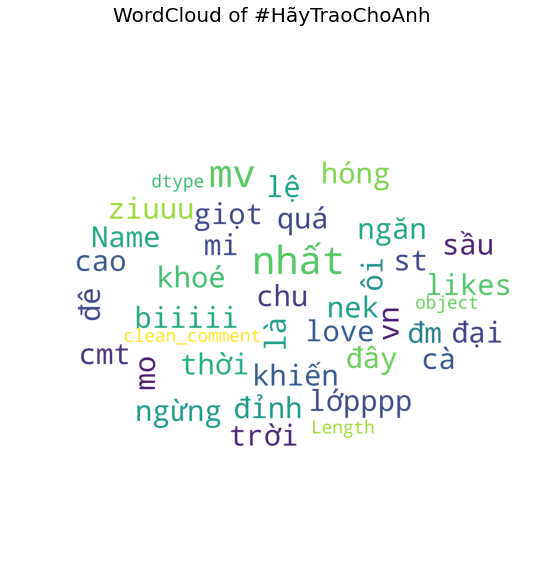

time: 2.52 s


In [ ]:
Neutral_sent = htca[htca['Like Count']== 0]
#pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
pos_mask = np.array(Image.open('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Vi dụ demo/comment.png'))
plot_wordcloud(Neutral_sent.clean_comment,mask=pos_mask,color='white',max_font_size=150,title_size=20,title="WordCloud of #HãyTraoChoAnh")

## Áp dụng Phân lớp #HãyTraoChoAnh

### TẠO MÔ HÌNH SIÊU VECTOR = SVM

In [ ]:
import pandas as pd
import numpy as np
import json

#Loading additional helper functions not shown here but provided in the folder
#%run nlp_utils_news.ipynb

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format


time: 17.5 ms


In [ ]:
#Đọc dữ liệu Train vào DataFrame

#ds = DataSource()
#train_data = pd.DataFrame(ds.load_data('/content/drive/My Drive/Colab Notebooks/10Project/Data5_NLP_02/data_clean/train.crash'))
#train_data = pd.DataFrame(ds.load_data('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Vi dụ demo/Data/data_clean/train.crash'))
train_data = pd.read_csv('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Data_Comment/underthesky1.csv')

train_data = train_data.rename(columns={'Unnamed: 0': 'ID', 'clean_comment': 'binh_luan'})
train_data.head(14000)

data_NLP = train_data
print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))

df= data_NLP

#Creating the features (tf-idf weights) for the processed text

texts = df['binh_luan'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label'].values #target

print (X.shape)
print(y.shape)

Done process at :  2020-11-13 12:55:47
(36000, 37295)
(36000,)
time: 1.14 s


In [ ]:
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(36000, 100)

time: 5.68 s


In [ ]:
#Preliminary model evaluation using default parameters
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              #'MultinomialNB': MultinomialNB(alpha=0.01),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'Super Vector Machine': LinearSVC(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

score_table = model_score_df(model_dict)
score_table

,model_name,accuracy_score,precision_score,recall_score,f1_score
6,Super Vector Machine,0.97,0.97,0.97,0.97
2,Random Forest,0.96,0.96,0.96,0.96
1,Stochastic Gradient Descent,0.96,0.96,0.96,0.96
3,Decsision Tree,0.93,0.93,0.93,0.93
4,AdaBoost,0.93,0.93,0.93,0.93
7,K Nearest Neighbor,0.87,0.88,0.87,0.87
5,Gaussian Naive Bayes,0.61,0.67,0.61,0.57
0,Dummy,0.33,0.33,0.33,0.33


time: 1min 18s


In [ ]:
# Phân tích các lơp SVM
#df1 = data_NLP
df = df.astype({"label": 'str'}) 
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X, 
                                                               y, 
                                                               df.index, test_size=0.25, 
                                                               random_state=3)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['label'].unique()))


				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

         1.0       0.99      0.97      0.98      3015
         0.0       0.94      1.00      0.97      2980
        -1.0       0.99      0.95      0.97      3005

    accuracy                           0.97      9000
   macro avg       0.98      0.97      0.97      9000
weighted avg       0.98      0.97      0.97      9000

time: 792 ms


In [ ]:
y_test

array([ 1.,  0.,  0., ..., -1.,  1.,  1.])

time: 2.49 ms


In [ ]:
y_pred

array([ 1.,  0.,  0., ..., -1.,  1.,  1.])

time: 3.06 ms


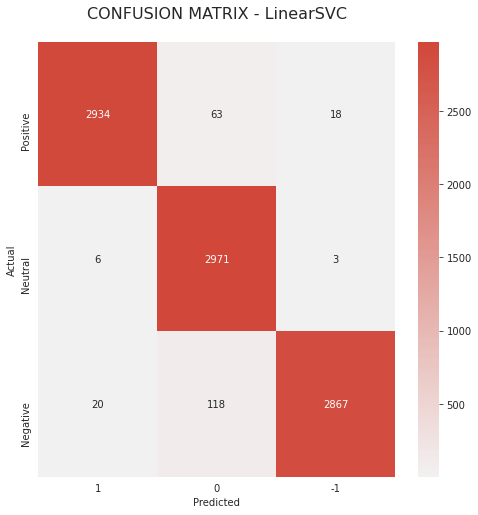

time: 264 ms


In [ ]:
#Confusion Matrix #UnderTheSky1 - SVM
cm = confusion_matrix(y_test, y_pred) 
#conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))

cm_df = pd.DataFrame(cm,
                     index = ['Positive','Neutral','Negative'], 
                     columns = ['1','0','-1'])
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')
'''
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=df.label.values, 
            yticklabels=df.label.values)
'''            
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);


---

In [ ]:
# Predictions - Dự đoán Cho cái mới


# Phân tích các lơp SVM
#df1 = data_NLP
#df = df.astype({"label": 'str'}) 


df1= data_NLP
df1 = df1.astype({"label": 'str'}) 
#Creating the features (tf-idf weights) for the processed text

texts1 = df1['binh_luan'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X1 = tfidf_vectorizer.fit_transform(texts1) #features
y1 = df1['label'].values #target


X_train1, X_test1, y_train1, y_test1,indices_train,indices_test = train_test_split(X1, 
                                                               y1, 
                                                               df1.index, test_size=0.25, 
                                                               random_state=3)

model = LinearSVC()
model.fit(X_train1, y_train1)
y_pred1 = model.predict(X_test1)

# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test1, y_pred1, 
                                    target_names= df1['label'].unique()))


				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99      3015
         0.0       0.97      1.00      0.99      2980
        -1.0       1.00      0.98      0.99      3005

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000

time: 1.67 s


In [ ]:
# Áp dụng Thử Nha:
print(' Áp Dụng Thử Nha:')
print('------------------------------------------------------')
print(" Ví dụ : ")
#new_binh_luan = """ Thầy Nam hát hayyyyyyyy quá ❤️, nhạc Sơn Tùng quá đỉnh nhưng giọng mình dở quá 😰, dù hát ko hay vẫn cứ hát 👍 yeahhhh"""
new_binh_luan = """ thks tks ! Thầy Nam hát hayyyyyyyy quá ❤️"""
#new_binh_luan = """ Thầy Nam hát hayyyyyyyy quá ❤️"""

new_binh_luan1=normalize_text(new_binh_luan)
print('Bình luận - Comment :',new_binh_luan)
print('------------------------------------------------------')
print('Text sau khi xử lý  : ', new_binh_luan1)
print('------------------------------------------------------')
print('Mô hình dự đoán     : ',model.predict(tfidf_vectorizer.transform([new_binh_luan1])))


 Áp Dụng Thử Nha:
------------------------------------------------------
 Ví dụ : 
Bình luận - Comment :  thks tks ! Thầy Nam hát hayyyyyyyy quá ❤️
------------------------------------------------------
Text sau khi xử lý  :  cám ơn cám ơn thầy nam hát hay quá positive  positive positive positive
------------------------------------------------------
Mô hình dự đoán     :  ['1.0']
time: 11.5 ms


In [ ]:
# Áp dụng Thử Nha:
print(' Áp Dụng Thử Nha:')
print('------------------------------------------------------')
print(" Ví dụ : ")
#new_binh_luan = """ Thầy Nam hát hayyyyyyyy quá ❤️, nhạc Sơn Tùng quá đỉnh nhưng giọng mình dở quá 😰, dù hát ko hay vẫn cứ hát 👍 yeahhhh"""
new_binh_luan = """  Mình thích hát nhưng giọng mình dở quá 😰"""
#new_binh_luan = """ Thầy Nam hát hayyyyyyyy quá ❤️"""

new_binh_luan1=normalize_text(new_binh_luan)
print('Bình luận - Comment :',new_binh_luan)
print('------------------------------------------------------')
print('Text sau khi xử lý  : ', new_binh_luan1)
print('------------------------------------------------------')
print('Mô hình dự đoán     : ',model.predict(tfidf_vectorizer.transform([new_binh_luan1])))


 Áp Dụng Thử Nha:
------------------------------------------------------
 Ví dụ : 
Bình luận - Comment :   Mình thích hát nhưng giọng mình dở quá 😰
------------------------------------------------------
Text sau khi xử lý  :  mình thích hát nhưng giọng mình dở quá negative positive negative
------------------------------------------------------
Mô hình dự đoán     :  ['-1.0']
time: 12.5 ms


In [ ]:
# Áp dụng Thử Nha:
print(' Áp Dụng Thử Nha:')
print('------------------------------------------------------')
print(" Ví dụ : ")
#new_binh_luan = """ Thầy Nam hát hayyyyyyyy quá ❤️, nhạc Sơn Tùng quá đỉnh nhưng giọng mình dở quá 😰, dù hát ko hay vẫn cứ hát 👍 yeahhhh"""
#new_binh_luan = """  Mình thích hát nhưng giọng mình dở quá 😰"""
new_binh_luan = """ dù hát ko hay vẫn cứ hát 👍 yeahhhh ❤️"""

new_binh_luan1=normalize_text(new_binh_luan)
print('Bình luận - Comment :',new_binh_luan)
print('------------------------------------------------------')
print('Text sau khi xử lý  : ', new_binh_luan1)
print('------------------------------------------------------')
print('Mô hình dự đoán     : ',model.predict(tfidf_vectorizer.transform([new_binh_luan1])))

 Áp Dụng Thử Nha:
------------------------------------------------------
 Ví dụ : 
Bình luận - Comment :  dù hát ko hay vẫn cứ hát 👍 yeahhhh ❤️
------------------------------------------------------
Text sau khi xử lý  :  dù hát notpos  vẫn cứ hát positive yeah positive 
------------------------------------------------------
Mô hình dự đoán     :  ['1.0']
time: 7.86 ms


In [ ]:
# Áp dụng Thử Nha:
print(' Áp Dụng Thử Nha:')
print('------------------------------------------------------')
print(" Ví dụ : ")
#new_binh_luan = """ Thầy Nam hát hayyyyyyyy quá ❤️, nhạc Sơn Tùng quá đỉnh nhưng giọng mình dở quá 😰, dù hát ko hay vẫn cứ hát 👍 yeahhhh"""
#new_binh_luan = """  Mình thích hát nhưng giọng mình dở quá 😰"""
new_binh_luan = """ Nhớ Thương Đầy Vơi Lòng Chơi Với ... Ngủ Sớm Cho Khỏe"""

new_binh_luan1=normalize_text(new_binh_luan)
print('Bình luận - Comment :',new_binh_luan)
print('------------------------------------------------------')
print('Text sau khi xử lý  : ', new_binh_luan1)
print('------------------------------------------------------')
print('Mô hình dự đoán     : ',model.predict(tfidf_vectorizer.transform([new_binh_luan1])))

 Áp Dụng Thử Nha:
------------------------------------------------------
 Ví dụ : 
Bình luận - Comment :  Nhớ Thương Đầy Vơi Lòng Chơi Với ... Ngủ Sớm Cho Khỏe
------------------------------------------------------
Text sau khi xử lý  :  nhớ thương đầy vơi lòng chơi với ngủ sớm cho khoẻ
------------------------------------------------------
Mô hình dự đoán     :  ['0.0']
time: 10.3 ms


---

In [ ]:
htca_p = pd.read_csv('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Data_Comment/Vander_htca.csv')
htca_p = htca_p[['clear_all', 'clean_comment', 'text_length', 'Like Count','label']]
htca_p = htca_p.astype({"clean_comment": 'str'}) 
#htca_p = train_data.rename(columns={'Unnamed: 0': 'ID', 'clean_comment': 'binh_luan'})
print ("Done process at : ", now.strftime("%Y-%m-%d %H:%M:%S"))
htca_p.head(10)

Done process at :  2020-11-13 12:55:47


,clear_all,clean_comment,text_length,Like Count,label
0,ngăn giọt lệ ngừng khiến khoé mi sầu biiiii,ngăn giọt lệ ngừng khiến khoé mi sầu bi,9.00,0.00,0.00
1,cá heo,cá_heo,2.00,1.00,0.00
2,mv đỉnh nhất vn thời đại,mv đỉnh nhất vn thời_đại positive,6.00,0.00,1.00
3,hay quá anh ơi,hay quá anh ơi positive,4.00,2.00,1.00
4,31/10 ai còn nghe ko,31 10 ai còn nghe ko,5.00,1.00,0.00
5,còn ai nghe k ta,còn ai nghe không ta,5.00,1.00,0.00
6,lớpppp ziuuu,lớp z yêu positive,2.00,0.00,1.00
7,i love u chu cà mo,i love u chu cà_mo,6.00,0.00,1.00
8,123 cái quạt hihi,123 cái quạt positive,4.00,1.00,1.00
9,giờ còn ai nghe :))\n31/10/2020,giờ còn ai nghe positive 31 10 2020,6.00,1.00,1.00


time: 1.49 s


In [ ]:
htca_p1

,clear_all,clean_comment,text_length,Like Count,label
0,ngăn giọt lệ ngừng khiến khoé mi sầu biiiii,ngăn giọt lệ ngừng khiến khoé mi sầu bi,9.00,0.00,0.00
1,cá heo,cá_heo,2.00,1.00,0.00
2,mv đỉnh nhất vn thời đại,mv đỉnh nhất vn thời_đại positive,6.00,0.00,1.00
3,hay quá anh ơi,hay quá anh ơi positive,4.00,2.00,1.00
4,31/10 ai còn nghe ko,31 10 ai còn nghe ko,5.00,1.00,0.00


time: 21.3 ms


In [ ]:
pd.set_option('display.max_rows', 10)
#htca_p = htca_p.astype({"clean_comment": 'str'})
#input=[input]
htca_p['Model_SVM'] = model.predict(tfidf_vectorizer.transform(htca_p['clean_comment']))
#
htca_p.head(10)

,clear_all,clean_comment,text_length,Like Count,label,Model_SVM
0,ngăn giọt lệ ngừng khiến khoé mi sầu biiiii,ngăn giọt lệ ngừng khiến khoé mi sầu bi,9.00,0.00,0.00,0.0
1,cá heo,cá_heo,2.00,1.00,0.00,0.0
2,mv đỉnh nhất vn thời đại,mv đỉnh nhất vn thời_đại positive,6.00,0.00,1.00,1.0
3,hay quá anh ơi,hay quá anh ơi positive,4.00,2.00,1.00,1.0
4,31/10 ai còn nghe ko,31 10 ai còn nghe ko,5.00,1.00,0.00,0.0
5,còn ai nghe k ta,còn ai nghe không ta,5.00,1.00,0.00,0.0
6,lớpppp ziuuu,lớp z yêu positive,2.00,0.00,1.00,1.0
7,i love u chu cà mo,i love u chu cà_mo,6.00,0.00,1.00,1.0
8,123 cái quạt hihi,123 cái quạt positive,4.00,1.00,1.00,1.0
9,giờ còn ai nghe :))\n31/10/2020,giờ còn ai nghe positive 31 10 2020,6.00,1.00,1.00,1.0


time: 6.72 s


186824  Vs  42002
407240
636066
186824


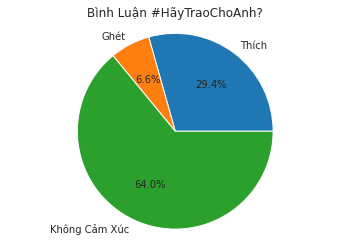

time: 774 ms


In [ ]:
htca_p['Model_SVM'] = htca_p['Model_SVM'].astype('float')
print(len(htca_p[htca_p.Model_SVM > 0]),' Vs ',len(htca_p[htca_p.Model_SVM< 0]))
print(len(htca_p[htca_p.Model_SVM ==0]))
print(len(htca_p.Model_SVM))
htca_p.isin([0]).sum()

x1 = len(htca_p[htca_p.Model_SVM > 0])
#k = len(htca_p [htca_p.label >0]) - x
y1 = len(htca_p[htca_p.Model_SVM < 0] )
z1 = len(htca_p[htca_p.Model_SVM == 0] )

print (x1)

import matplotlib.pyplot as plt
pie = [x1,y1,z1]
my_labels = 'Thích' ,'Ghét','Không Cảm Xúc'
plt.pie(pie,labels=my_labels,autopct='%1.1f%%')
plt.title('Bình Luận #HãyTraoChoAnh?')
plt.axis('equal')
plt.show()

195051  Vs  40575
286236
636066
195051


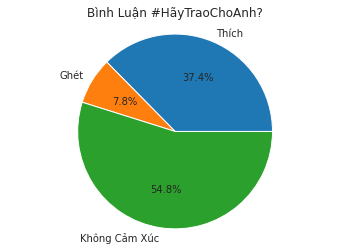

time: 596 ms


In [ ]:
print(len(htca_p[htca_p.label > 0]),' Vs ',len(htca_p[htca_p.label < 0]))
print(len(htca_p[htca_p .label ==0]))
print(len(htca_p.label))
htca_p.isin([0]).sum()

x = len(htca_p[htca_p.label > 0])
#k = len(htca_p [htca_p.label >0]) - x
y = len(htca_p[htca_p.label < 0] )
z = len(htca_p[htca_p.label == 0] )

print (x)

import matplotlib.pyplot as plt
pie = [x,y,z]
my_labels = 'Thích' ,'Ghét','Không Cảm Xúc'
plt.pie(pie,labels=my_labels,autopct='%1.1f%%')
plt.title('Bình Luận #HãyTraoChoAnh?')
plt.axis('equal')
plt.show()

### Áp dụng Phân lớp cho #HãyTraoChoAnh

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ["Thích", "Ghét", "Không Cảm Xúc"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[x, y, z], name="PhânLớp ByHand"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=[x1,y1,z1], name="Phân Lớp SVM"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="So sánh mô hình Phân Lớp Học Máy #HãyTraoChoAnh",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Bằng Tay', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Model SVM', x=0.835, y=0.5, font_size=20, showarrow=False)])
fig.show()

time: 13.2 ms


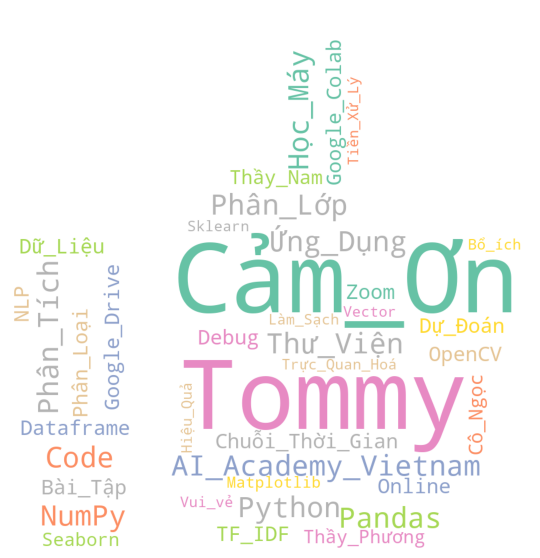

time: 1.25 s


In [ ]:
text =('AI_Academy_Vietnam Python Học_Máy Phân_Lớp Thư_Viện NumPy Pandas Code Phân_Tích Cảm_Ơn Ứng_Dụng Chuỗi_Thời_Gian Dự_Đoán TF_IDF Phân_Loại\
 Dataframe NLP OpenCV Debug Bài_Tập Google_Drive Google_Colab Online Zoom Dữ_Liệu Thầy_Nam Cô_Ngọc Thầy_Phương Tommy Cảm_Ơn\
 Seaborn Matplotlib Trực_Quan_Hoá Làm_Sạch Tiền_Xử_Lý Hiệu_Quả Sklearn Vector Vui_vẻ Bổ_ích Tommy')

# Import packages
import matplotlib.pyplot as plt
%matplotlib inline

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(10, 10))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");



# Import packages
import numpy as np
from PIL import Image# Import image to np.array
mask = np.array(Image.open('/content/drive/My Drive/10 Kaggle Projects/AAAFinal Project/Vi dụ demo/Thumbs.png'))# Generate wordcloud
wordcloud = WordCloud(width = 1000, height = 600, random_state=1, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS, mask=mask).generate(text)# Plot
plot_cloud(wordcloud)

## WHY IS IT?

# Xử lý EMOJI 
+ testing

In [ ]:
redefined = {
    '👑': '_best',
    '🧐': '_skeptical',
    '💩': '_shit',
    '🌷': '_beautiful',
    '🌹': '_affection',
    '👍': '_good',
    '🤪': '_crazy',
    '💅': '_indifferent',
    '🙉': '_amuse',
    '🙄': '_disappoint',
    '🔥': '_great!',
    '👏': '_applause',
    '😒': '_not amused',
    '😝': '_playful',
    '💔': '_sad', 
    '😋': '_delicious',
    '🤢': '_bad',
    '👎': '_bad',
    '👸': '_good',
    '🌼': '_appreciate',
    '🖕': '_bad',
    '✊': '_good',
    '😑': '_bored',
    '🌝': '_irony',
    '🤩': '_wow',
    '💯': '_great',
    '🤮': '_disgust',
    '🙂': '_satisfied',
    '🥱': '_bored',
    '😪': '_tired',
    '😣': '_frustration',
    '😜': '_fun',
    '🙈': '_oh my god',
    '😳': '_surprise',
    '🤷': '_indifference',
    '🥺': '_please',
    '🤬': '_curse',
    '🥵': '_sexy',
    '🌟': '_brilliant',
    '👁👄👁': '_confuse',
    '🤯': '_wow',
    '🤡': '_fool',
    '😆': '_haha',
    '😷': '_sick',
    '✔️': '_approval',
    '🤟': '_love',
    '🤨': '_skeptical',
    '😏': '_satisfaction',
    '🌚': '_ironic',
    '😐': '_irritation',
    '💄': '_glamour',
    '😖': '_frustrate',
    '🎊': '_congratulations',
    '😜': '_playful',
    '😡': '_anger',
    '😯': '_surprise',
    '🤭': '_shock',
    '🙃': '_frustration',
    '👊': '_celebrate',
    '💪': '_strong',
    '😶': '_awkward',
    '😥': '_sad',
    '🤤': '_yummy',
    '🤍': '_heart',
    '✔️': '_good',
    '😤': '_pride',
    '💥': '_wow',
    '🙏': '_blessing',
    '💣': '_amazing',
    '💫': '_great',
    '🤧': '_good',
    '💀': '_shock',
    'kill': '_great',
    'killed': '_great',
    'killing': '_great',
    '😂': '_obnoxious'        
}
import json
with open('redefined.json', 'w') as fp:
    json.dump(redefined, fp)

In [ ]:
with open('redefined.json', 'r') as fp:
    redefined_meaning = json.load(fp)
# testing chuyển emoji sang chữ
redefined_meaning['🔥']

'_great!'

In [ ]:
def replace_emojis_or_word(text, redefined_meaning):
    new_text = []
    text = re.split(r'(\s+)', text)
    
    for word in text:
        has_emoji = False
        idx_begin = 0
        for idx_end, letter in enumerate(word):
            if any(char in emoji.UNICODE_EMOJI for char in letter):
                # append non-emoji text
                new_text += redefined_meaning.get(word[idx_begin:idx_end], word[idx_begin:idx_end]) + ' '
                # set new head to one after current idx_end
                idx_begin = idx_end + 1

                # add the emoji we just found
                new_text += redefined_meaning.get(letter, letter) + ' '
                has_emoji = True

        if not has_emoji:
            new_text += redefined_meaning.get(word, word)

    return ''.join(new_text)
# Testing 
replace_emojis_or_word('Owh my budda- SonTung is so handsome 😮😮😮', redefined_meaning)

'Owh my budda- SonTung is so handsome  😮  😮  😮 '

In [ ]:
blackpink['Modified Emojis and Words'] = [replace_emojis_or_word(comment, redefined_meaning) for comment in stripped_urls]
blackpink.head(10)

,Comment,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating,Lang,Stripped Urls,Stripped Emojis,Stripped Symbols,lowercase_and_all_stripped,expanded_langs,Modified Emojis and Words
0,LẠC TRÔI (TRIPLE D REMIX) | 360 DEGREE MV | S...,UgxkMePlfTxtvesUSJl4AaABAg,446,27362,none,2017-09-08T13:16:21Z\r,lang,LẠC TRÔI (TRIPLE D REMIX) | 360 DEGREE MV | S...,LẠC TRÔI (TRIPLE D REMIX) | 360 DEGREE MV | S...,LẠC TRÔI TRIPLE D REMIX DEGREE MV SƠN TÙNG M T...,lạc trôi (triple d remix) | 360 degree mv | s...,Vietnamese,LẠC TRÔI (TRIPLE D REMIX) | 360 DEGREE MV | S...
1,Còn ai nghe bài này k,Ugwkpg6M_6W1BR2gux14AaABAg,0,1,none,2020-10-31T03:16:38Z\r,lang,Còn ai nghe bài này k,Còn ai nghe bài này k,Còn ai nghe bài này k,còn ai nghe bài này k,Vietnamese,Còn ai nghe bài này k
2,Nguoi theo huong hoa,UgwP9JhVu_QeC2Sl9fx4AaABAg,0,1,none,2020-10-31T03:16:29Z\r,lang,Nguoi theo huong hoa,Nguoi theo huong hoa,Nguoi theo huong hoa,nguoi theo huong hoa,unsure,Nguoi theo huong hoa
3,nhạc của Sơn Tùng vẫn hay nhất 1 /11 / 2020,UgxffF52k7LTUQf7h5N4AaABAg,0,1,none,2020-10-31T01:50:03Z\r,lang,nhạc của Sơn Tùng vẫn hay nhất 1 /11 / 2020,nhạc của Sơn Tùng vẫn hay nhất 1 /11 / 2020,nhạc của Sơn Tùng vẫn hay nhất,nhạc của sơn tùng vẫn hay nhất 1 /11 / 2020,Vietnamese,nhạc của Sơn Tùng vẫn hay nhất 1 /11 / 2020
4,Dinh cao am nhac,UgzcxjXdrNYSiT041BR4AaABAg,0,1,none,2020-10-31T01:45:36Z\r,lang,Dinh cao am nhac,Dinh cao am nhac,Dinh cao am nhac,dinh cao am nhac,unsure,Dinh cao am nhac
5,08:02,UgxMeIugr1A3Jo1z9_t4AaABAg,0,2,none,2020-10-31T01:01:48Z\r,non-alphanum,08:02,08:02,,08:02,NaN,08:02
6,Cố 800K nha,UgwPfFkfdwgTRhwyXJR4AaABAg,1,3,none,2020-10-31T00:33:35Z\r,lang,Cố 800K nha,Cố 800K nha,Cố 800K nha,cố 800k nha,Vietnamese,Cố 800K nha
7,ai còn xem?,Ugw9soLs_PO9rFtNLpN4AaABAg,1,2,none,2020-10-30T23:10:36Z\r,lang,ai còn xem?,ai còn xem?,ai còn xem,ai còn xem?,unsure,ai còn xem?
8,"Ko hiểu sao viết đc bài này !!! 1 từ thôi "" Đỉ...",UgziOhGfKmXspR_Hy4p4AaABAg,0,2,none,2020-10-30T17:02:24Z\r,lang,"Ko hiểu sao viết đc bài này !!! 1 từ thôi "" Đỉ...","Ko hiểu sao viết đc bài này !!! 1 từ thôi "" Đỉ...",Ko hiểu sao viết đc bài này từ thôi Đỉnh,"ko hiểu sao viết đc bài này !!! 1 từ thôi "" đỉ...",Vietnamese,"Ko hiểu sao viết đc bài này !!! 1 từ thôi "" Đỉ..."
9,hello sky,UgyUxKjX92Y3272O6sV4AaABAg,1,2,none,2020-10-30T16:56:34Z\r,lang,hello sky,hello sky,hello sky,hello sky,unsure,hello sky


In [ ]:
strip_symbols("**Hello there beautiful😮😮😮")


'Hello there beautiful'

In [ ]:
def keep_emojis_strip_symbols(text):
    stripped = []
    
    text_to_words = text.split()
    for word in text_to_words:
        data = regex.findall(r'\X', word)
        has_emoji = False
        the_emoji = []
        for char_combo in data:
            if any(char in emoji.UNICODE_EMOJI for char in char_combo):
                has_emoji = True
                break
            else:
                continue
                
        # after analyzing the characters of a word
        if has_emoji:
            stripped.append(''.join(word))
        else:
            stripped.append(strip_symbols(word))
    return ' '.join(stripped)
# tesitng
keep_emojis_strip_symbols("owh my goot Thay Nam is so excellent 😮 😮 😮")



'owh my goot Thay Nam is so excellent 😮 😮 😮'

In [ ]:
#!python -m spacy download en 
!pip3 install spacy
#!python3 -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 3.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=bf5575aeea4566e8c595c1a14f4ab15a0107bfc8f4b06dd7e9c595da7d34da03
  Stored in directory: /tmp/pip-ephem-wheel-cache-sp5u1jqi/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
time: 39.7 s


In [ ]:
!pip install <model_s3_url> # tar.gz file e.g. from release notes like https://github.com/explosion/spacy-models/releases//tag/en_core_web_lg-2.3.1
!pip install en_core_web_md


/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `pip install <model_s3_url> # tar.gz file e.g. from release notes like https://github.com/explosion/spacy-models/releases//tag/en_core_web_lg-2.3.1'


In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_md")
import en_core_web_md
nlp = en_core_web_md.load()

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
time: 17.2 s


In [ ]:
#!pip install -U spacy
#!pip install spacy
import spacy
import en_core_web_md

nlp = en_core_web_md.load()
#nlp = spacy.load('en_core_web_md')

def clean_comments(document):
    cleaned = []
    for comment in nlp.pipe(document, disable=['parser']):
        sentence = [keep_emojis_strip_symbols(word.lemma_) \
                    if word.lemma_ != '-PRON-' else word.text \
                    for word in comment]
        cleaned.append(' '.join(sentence))
    return cleaned



time: 16.3 s


In [ ]:
def get_emojis(text):
    just_emojis = ""
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            just_emojis += word
    return Counter(just_emojis)
all_emojis = Counter(get_emojis("".join(stripped_urls)))
print(len(all_emojis))

341
time: 240 ms


In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


time: 2.28 s


In [ ]:
emojis = pd.DataFrame.from_dict(all_emojis.items())

emojis.columns = ['emoji', 'emoji_count']

emojis.head()

emojis['sentiment'] = [analyzer.polarity_scores(an_emoji)['compound'] for an_emoji in emojis['emoji']]

time: 18.9 ms


In [ ]:
emojis.shape

(341, 3)

time: 2.66 ms


In [ ]:
emojis.head(10)

,emoji,emoji_count,sentiment
0,😁,85,0.4588
1,😌,4,0.3818
2,😊,89,0.7184
3,😂,130,0.4404
4,🥰,123,0.8074
5,🤭,5,0.4939
6,👇,233,0.0000
7,👍,212,0.0000
8,😍,404,0.4588
9,😘,211,0.4215


time: 15.9 ms


In [ ]:
emojis.describe()

,emoji_count,sentiment
count,341.000000,341.000000
mean,18.014663,0.069109
std,70.821792,0.252905
min,1.000000,-0.700300
25%,1.000000,0.000000
50%,4.000000,0.000000
75%,11.000000,0.000000
max,963.000000,0.807400


time: 19.7 ms


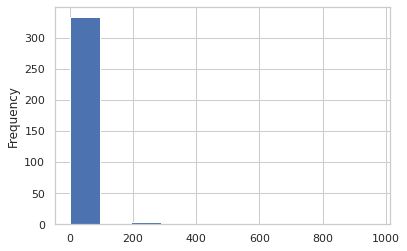

time: 268 ms


In [ ]:
emojis['emoji_count'].plot.hist()

In [ ]:
emojis.nlargest(10, 'emoji_count')

,emoji,emoji_count,sentiment
10,❤,963,0.6369
11,️,666,0.0000
8,😍,404,0.4588
6,👇,233,0.0000
7,👍,212,0.0000
9,😘,211,0.4215
3,😂,130,0.4404
4,🥰,123,0.8074
39,♥,96,0.6369
36,🤣,91,0.4939


time: 16.5 ms


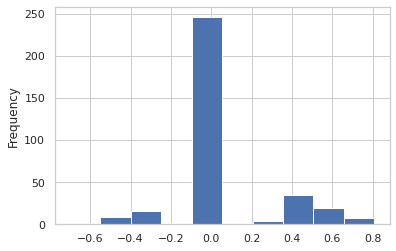

time: 286 ms


In [ ]:
emojis['sentiment'].plot.hist()

In [ ]:
neutral = emojis[(-0.05 < emojis.sentiment) & (emojis.sentiment < 0.05)]
neutral_toptwenty = neutral.nlargest(20, 'emoji_count')
neutral_toptwenty['text'] = [emoji.demojize(str(an_emoji)) for an_emoji in neutral_toptwenty['emoji']]

neutral_toptwenty

,emoji,emoji_count,sentiment,text
11,️,666,0.0,
6,👇,233,0.0,:backhand_index_pointing_down:
7,👍,212,0.0,:thumbs_up:
133,‍,52,0.0,‍
143,👏,51,0.0,:clapping_hands:
24,🇳,42,0.0,:regional_indicator_symbol_letter_n:
166,🤩,42,0.0,:star-struck:
23,🇻,36,0.0,:regional_indicator_symbol_letter_v:
34,🌻,33,0.0,:sunflower:
50,▪,31,0.0,:black_small_square:


time: 154 ms


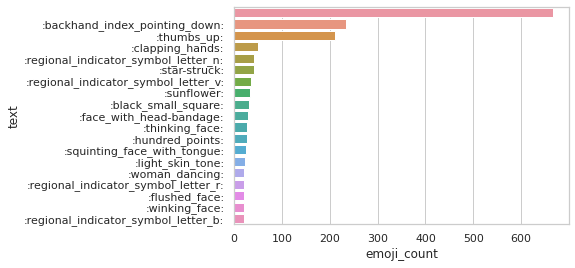

time: 354 ms


In [ ]:
#neutral_toptwenty.drop(11, axis='index', inplace=True)
neutral_toptwenty.drop(133, axis='index', inplace=True)
sns.barplot(y=neutral_toptwenty['text'], x=neutral_toptwenty['emoji_count'])

In [ ]:
neutral_toptwenty

,emoji,emoji_count,sentiment,text
11,️,666,0.0,
6,👇,233,0.0,:backhand_index_pointing_down:
7,👍,212,0.0,:thumbs_up:
143,👏,51,0.0,:clapping_hands:
24,🇳,42,0.0,:regional_indicator_symbol_letter_n:
166,🤩,42,0.0,:star-struck:
23,🇻,36,0.0,:regional_indicator_symbol_letter_v:
34,🌻,33,0.0,:sunflower:
50,▪,31,0.0,:black_small_square:
92,🤕,30,0.0,:face_with_head-bandage:


time: 14.1 ms


# IGNORGE THE BLOW LINE 
# ---------------- TESTING ONLY------------------------------------